# Mineração de Dados

**Prof. Dr. Sergio N. Simões**  
**Pós-graduação em Desenvolvimento de Aplicações Inteligentes**  
**Mineração de Dados — Trabalho 01**

**Nome:** Otávio Lube dos Santos  
**Matrícula:** 20231DEVAI0157

# Customer Segmentation Model

This notebook contains a clustering exercise used to practice model interpretation of grouped data. The hardest part about building a clustering model is generally understanding the results it outputs, as you don't have a target variable that you can compare your results with. 

Therefore, interpretation can become quite complex and so we explore a couple of alternatives for understanding your clusters once you have trained your model. Below are the steps taken to clean up the data, exploring it and finally fitting it to a K-Means clustering model and interpreting the results.

I belive the most important part of this exercise is the clustering interpretation, as every time we perform this type of unsupervised task we should be aware that the end goal is to provide business insights through the results.

If you like the notebook, don't forget to **upvote!!**

### Imports and information about the variables:

Variable description including type, range and full description:

| Variable | Data Type | Range | Description |
| --- | --- | --- | --- |
| ID | numerical | Integer | Shows a unique identificator of a customer. |
| Sex | categorical | {0,1} | Biological sex (gender) of a customer. 0 = male / 1 = female |
| Marital status | categorical | {0,1} | Marital status of a customer. 0 = single / 1 = non-single |
| Age | numerical | Integer | The age of the customer in years, calculated as current year minus the year of birth of the customer at the time of creation of the dataset (Min. age = 18 / Max. age = 78) |
| Education | categorical | {0,1,2,3} | Level of education of the customer. 0=no education / 1=high-school / 2=university / 3=graduate |
| Income | numerical | Real | Self-reported annual income in US dollars of the customer. |
| Occupation | categorical | {0,1,2} | Category of occupation of the customer. 0=unemployed / 1=employee/oficial / 2=management or self-employed |
| Settlement size | categorical | {0,1,2} | The size of the city that the customer lives in. 0=small / 1=mid-size / 2=big |

**Imports:**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Loading the dataset

In [4]:
customer_info = pd.read_csv('segmentation_data.csv')
customer_info.sample(5)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
693,100000694,0,0,44,1,110374,0,0
831,100000832,1,1,23,1,97115,1,2
558,100000559,0,0,27,0,115638,1,0
243,100000244,1,1,27,1,100008,1,0
26,100000027,0,1,39,1,68264,0,0


### General info on the dataset:

We'll first run a quick statistical analysis of the data. We will check for null values, get the general sense of the data and the types, to see if they reflect what's shown in the table above. We use:

- The .info() method on the DataFrame to understand the data types in each column. We notice there are no missing values and that all columns have numerical values in them.
- The .describe() method on the DataFrame shows summary info on the regular statistics you may apply to categorical/numerical data.

In [5]:
customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [6]:
num_columns = ['ID','Age','Income']
cat_columns = ['Sex','Marital status','Education','Occupation','Settlement size']

customer_info[cat_columns] = customer_info[cat_columns].astype('str')

In [7]:
customer_info.describe(include='object').T

,count,unique,top,freq
Sex,2000,2,0,1086
Marital status,2000,2,0,1007
Education,2000,4,1,1386
Occupation,2000,3,1,1113
Settlement size,2000,3,0,989


In [8]:
customer_info.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2000.0,1.000010e+08,577.494589,100000001.0,1.000005e+08,100001000.5,1.000015e+08,100002000.0
Age,2000.0,3.590900e+01,11.719402,18.0,2.700000e+01,33.0,4.200000e+01,76.0
Income,2000.0,1.209544e+05,38108.824679,35832.0,9.766325e+04,115548.5,1.380722e+05,309364.0


### Missing values

We've seen from the .info() method that there are no missing values.

## EDA

We start by taking a look at the distributions of the numerical variables Age, ID and Income. 

- We notice ID has a uniform distribution, which makes sense since it is an identifier of the customer and it will be dropped below.
- The variable 'Age' has a heavy right skew, generated because of the lower limit at zero of the variable. If we are using K-Means clustering, there will be no need to normalize the feature, but we may have to do so for other models.
- The feature 'Income' has the same right skew problem as the 'Age' feature. We'll have to be wary of this depending on the model we select.

#### Numerical Variables Distribution

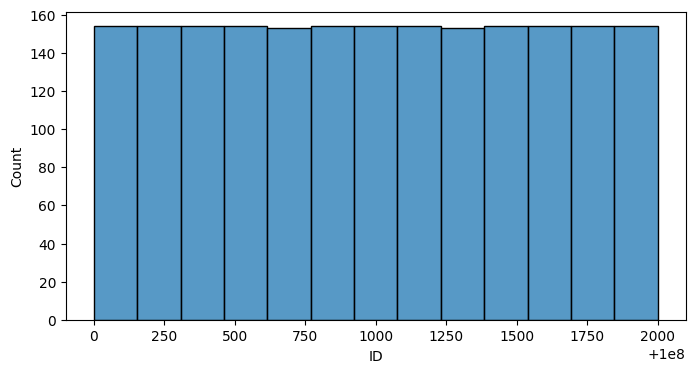

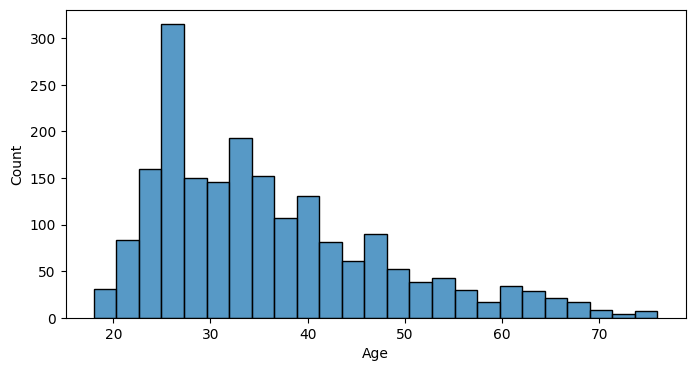

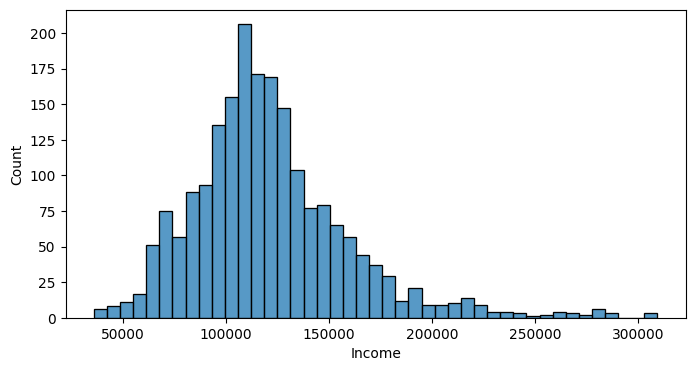

In [9]:
for numerical in num_columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data=customer_info, x=numerical)
    plt.savefig(numerical + '.png')

#### Categorical Variables Distribution

Next, we take a look at categorical variables. Running univariant countplots, we reach the following conclusions:

- Customer genders are quite balanced
- Marital status is also balanced 
- Most customers have highschool level education. There are only 1,8% graduate students. We could join both categories ('2' and '3') in a category called university & over
- Both the 'Occupation' and 'Settlement size' features seem to have a larger enough quantity of instances of each category.

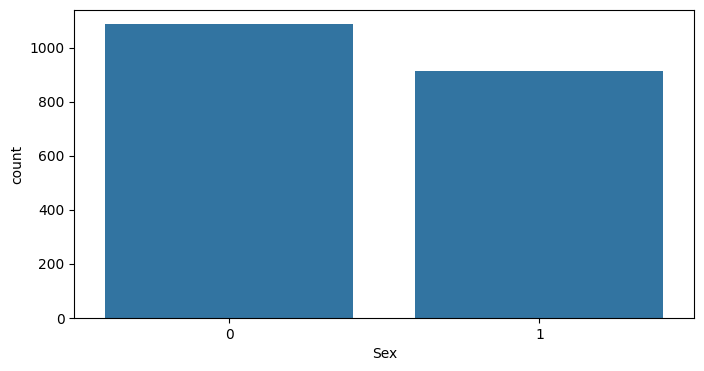

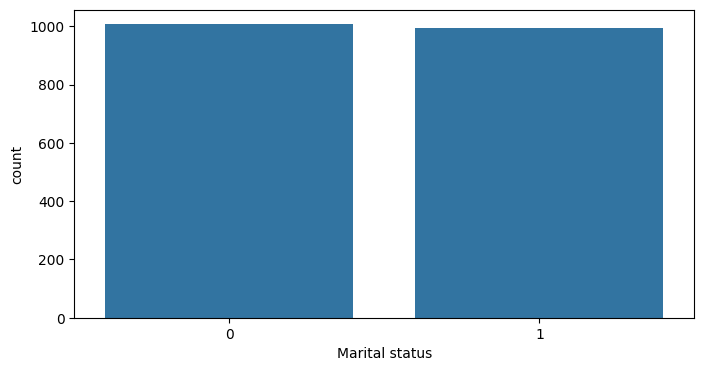

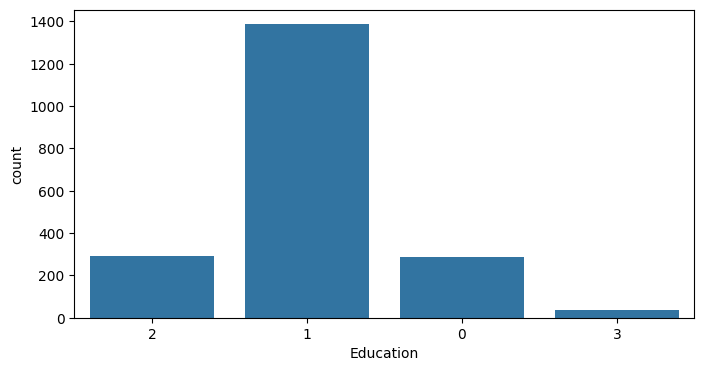

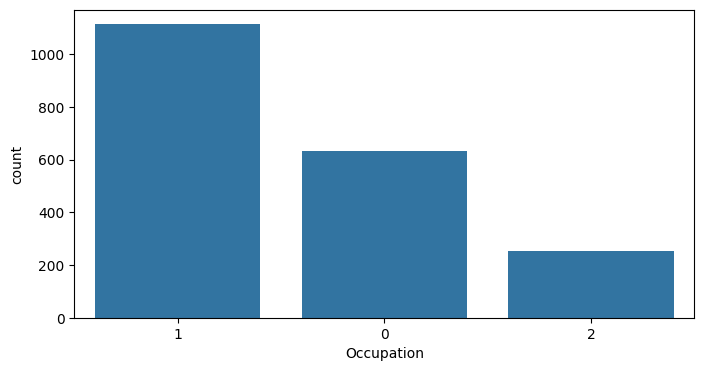

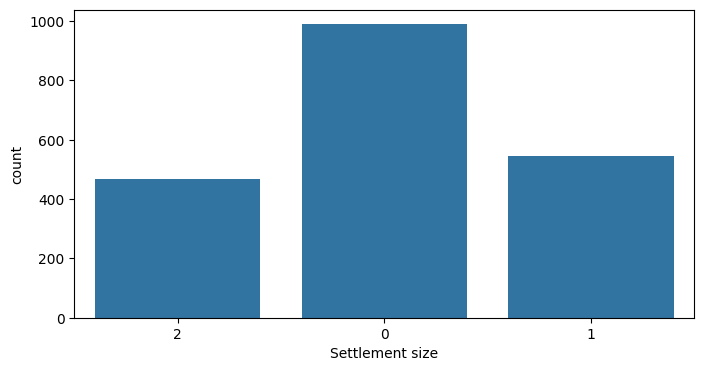

In [10]:
for category in cat_columns:
    plt.figure(figsize=(8,4))
    sns.countplot(data=customer_info, x=category)

### Bivariate Analysis

#### Numerical Features

<Axes: xlabel='Age', ylabel='Income'>

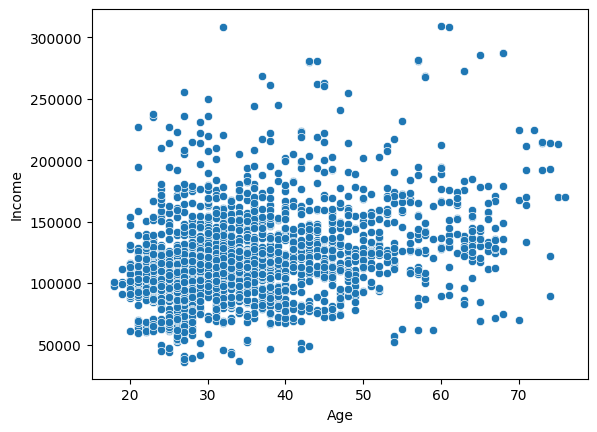

In [11]:
sns.scatterplot(x='Age', y='Income', data=customer_info)

There is some small correlation between the Age and Income features. We notice that the slope of the line is very small, which shows that the correlation between the features is low. Below we can see the calculation of the Pearson correlation factor, which states that values have a small correlation between them.

In [12]:
import scipy.stats as stats
print(stats.pearsonr(customer_info['Age'], customer_info['Income']))

PearsonRResult(statistic=np.float64(0.3406101637317351), pvalue=np.float64(1.644382544238683e-55))


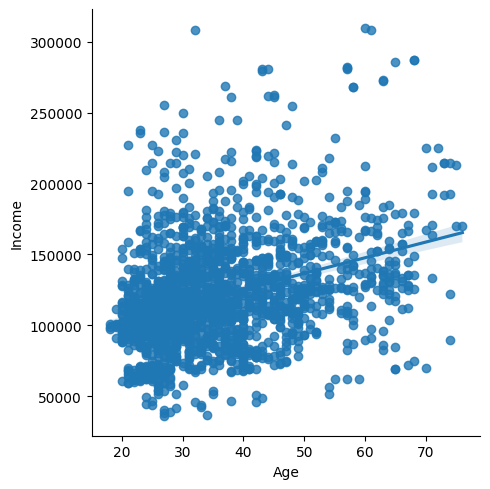

In [13]:
sns.lmplot(x='Age', y='Income', data=customer_info)

#### Categorical vs Numerical

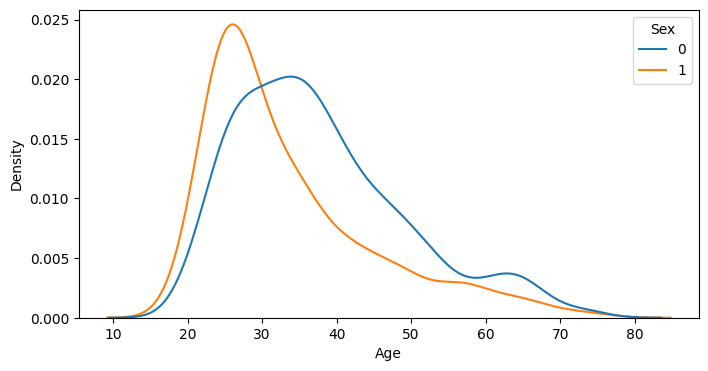

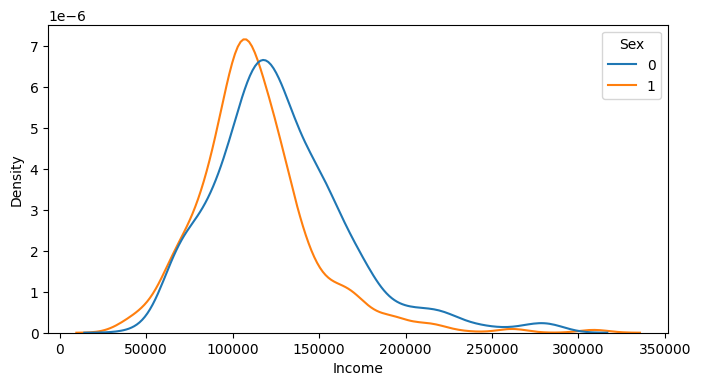

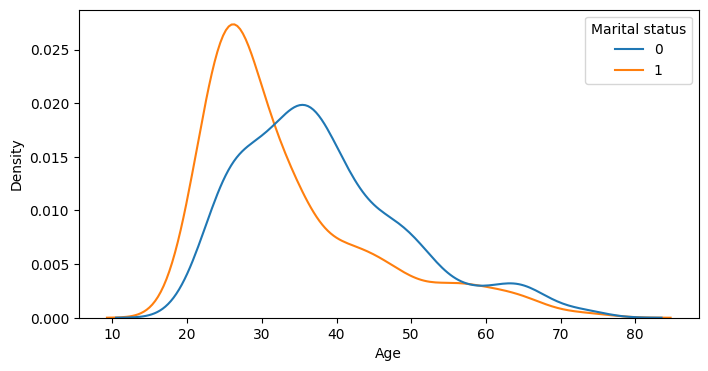

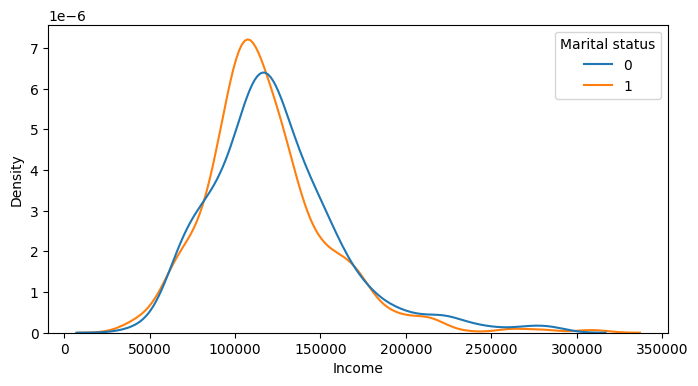

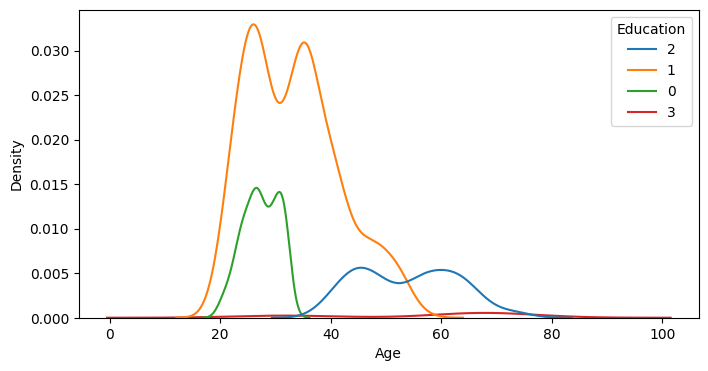

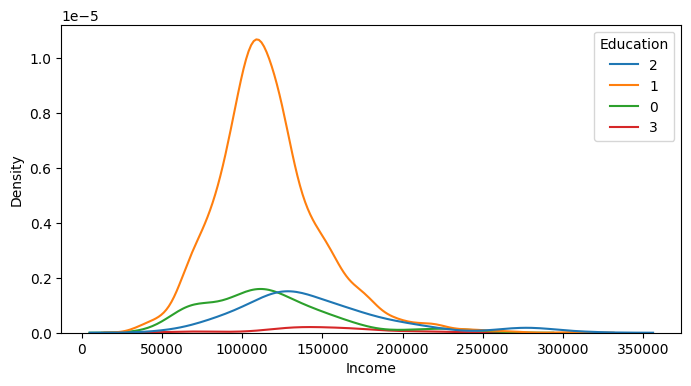

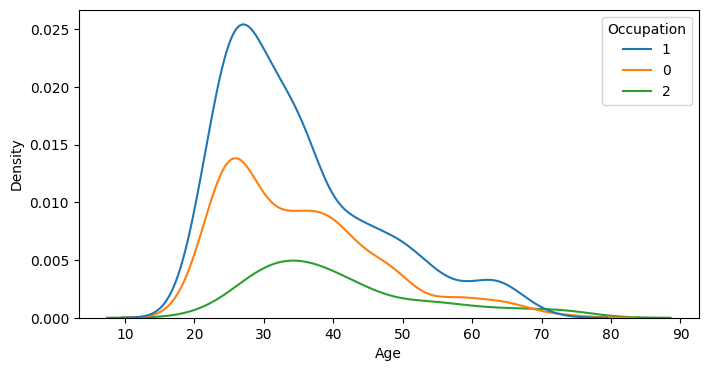

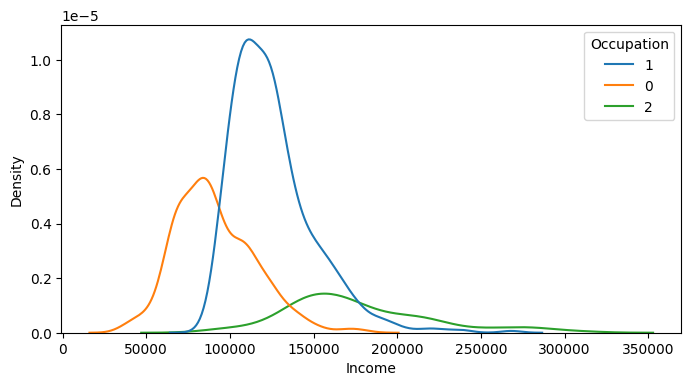

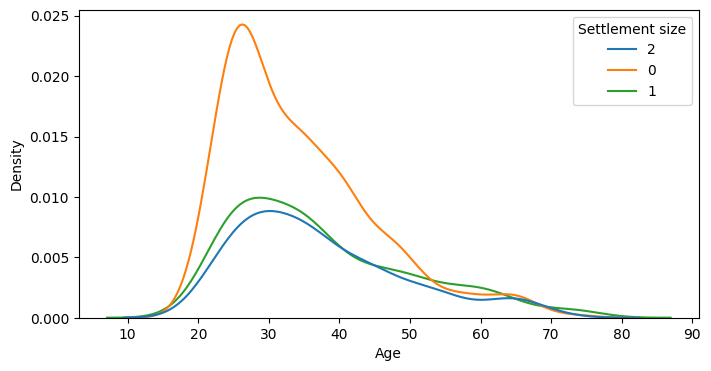

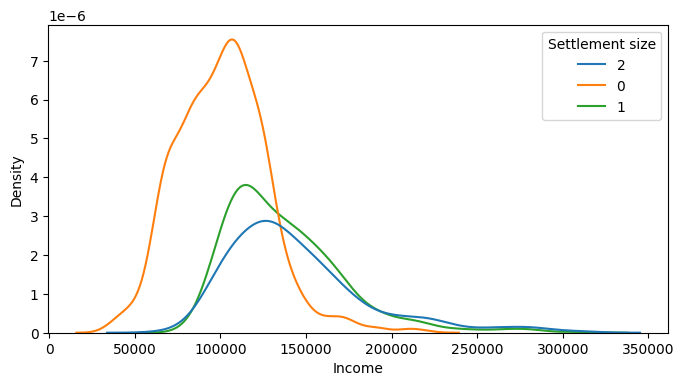

In [14]:
for category in cat_columns:
    for numerical in num_columns:
        if numerical != 'ID':
            plt.figure(figsize=(8,4))
            sns.kdeplot(data=customer_info, x=numerical, hue=category) ## Non-normalized version of this plot by switching kdeplot for histplot

#### Categorical vs Categorical

In [15]:
cat_columns

['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']

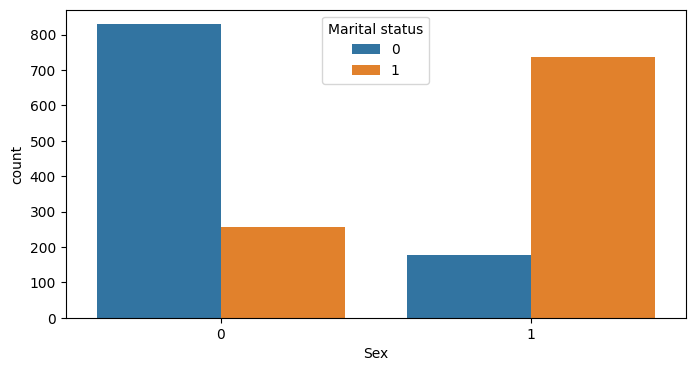

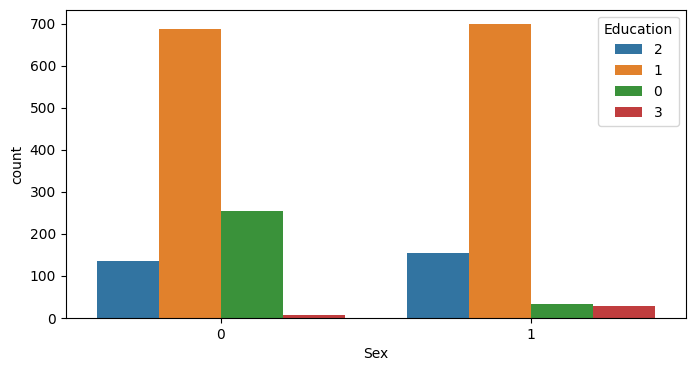

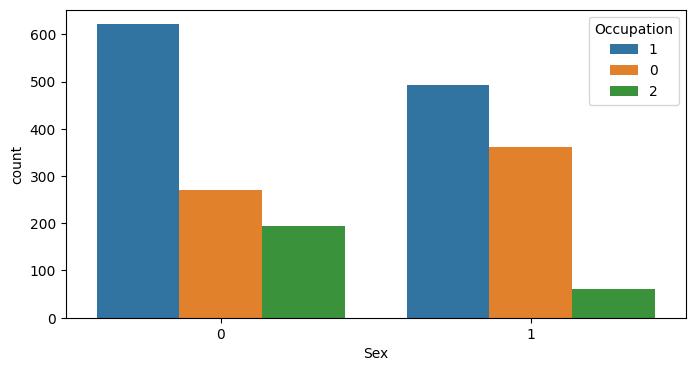

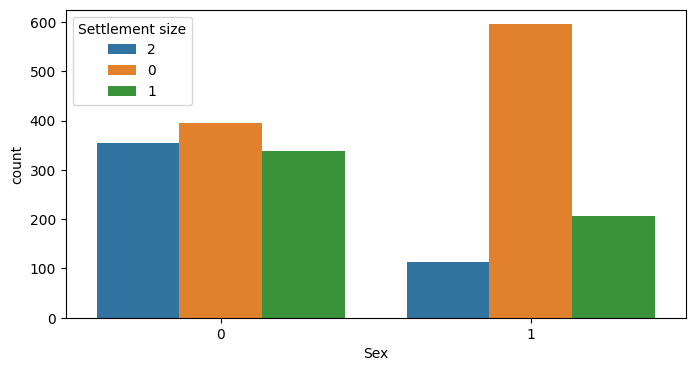

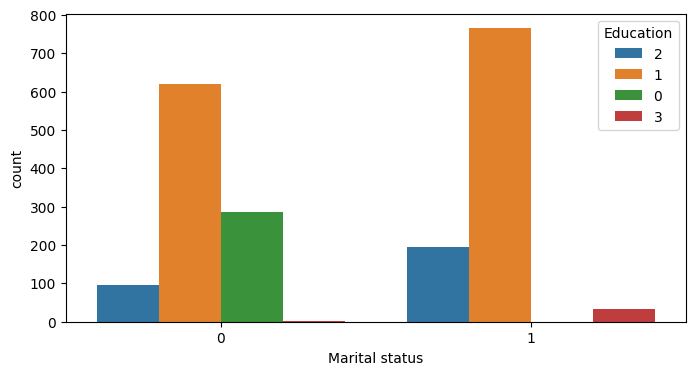

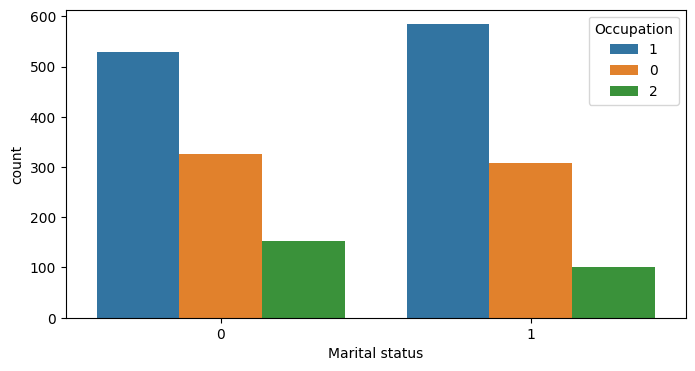

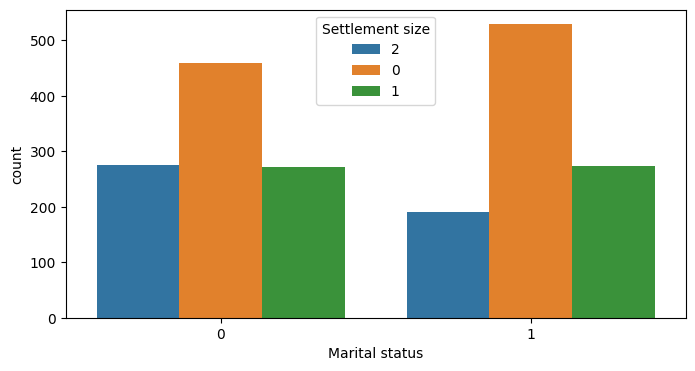

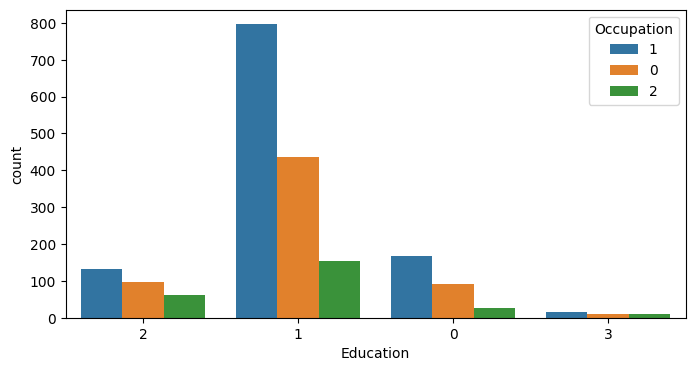

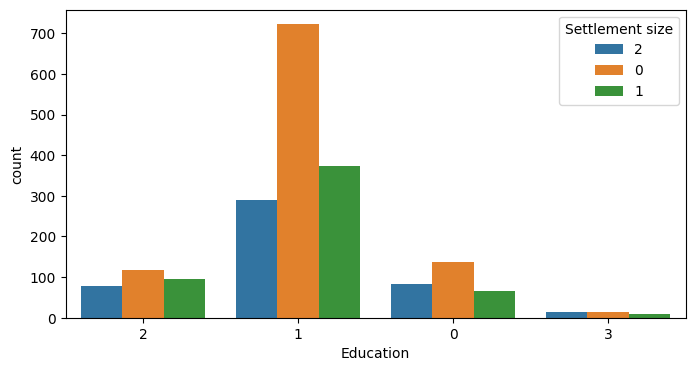

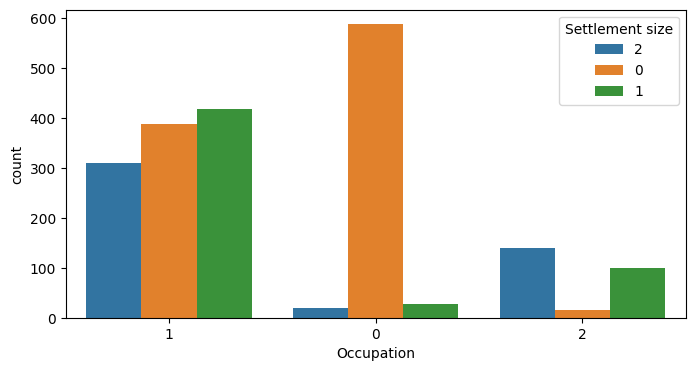

In [16]:
cat_aux = cat_columns.copy()
for category1 in cat_columns:
    cat_aux.pop(0);
    for category2 in cat_aux:
        if category1 != category2:
            plt.figure(figsize=(8,4))
            sns.countplot(data=customer_info, x=category1, hue=category2)

There are a few interesting relationships that can be drawn from the data:

1) People with Occupation = '0' (unemployed) tend to live in small cities within the customers
2) Married people tend to have either highschool-level or post-graduate-level educations within the customers
3) Married people also tend to live in smaller cities
4) Women within the customer list tend to be married more often than men
5) Males tend to be employed more often within the customer list. Women within the dataset, on the other hand, tend to be unemployed more often

### Multivariate Analysis

In [17]:
def bivariate_scatter(x, y, hue, df):
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=x, y=y, data=df, hue=hue, alpha=0.85)

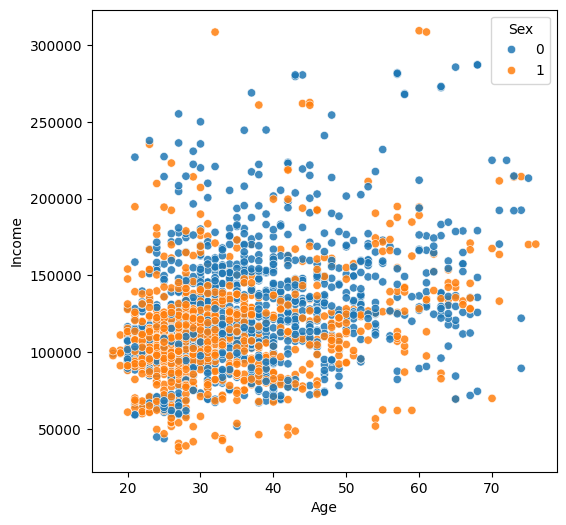

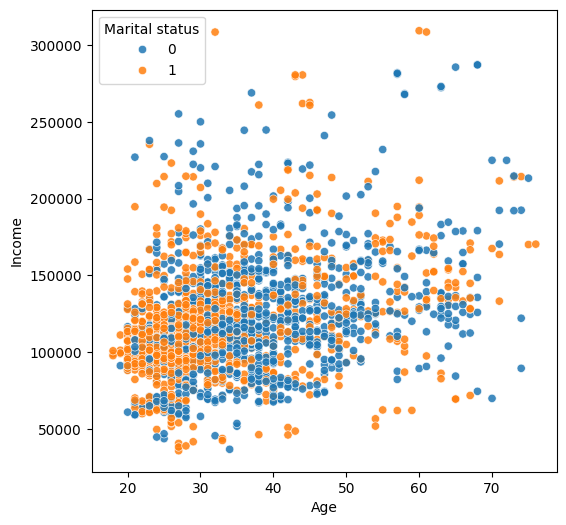

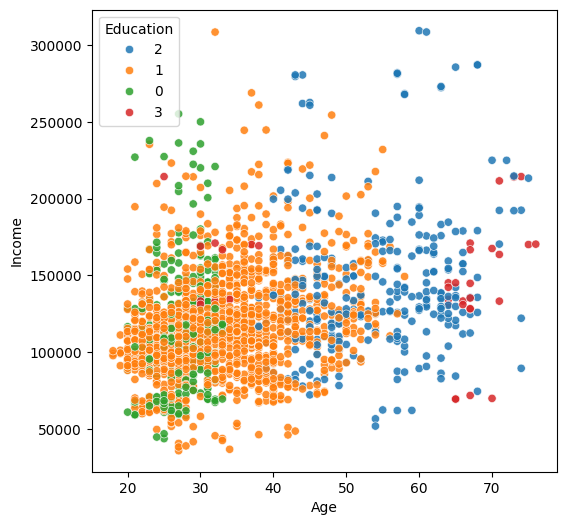

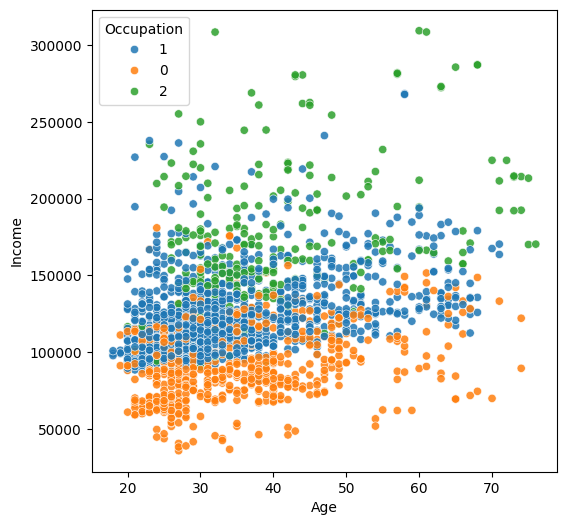

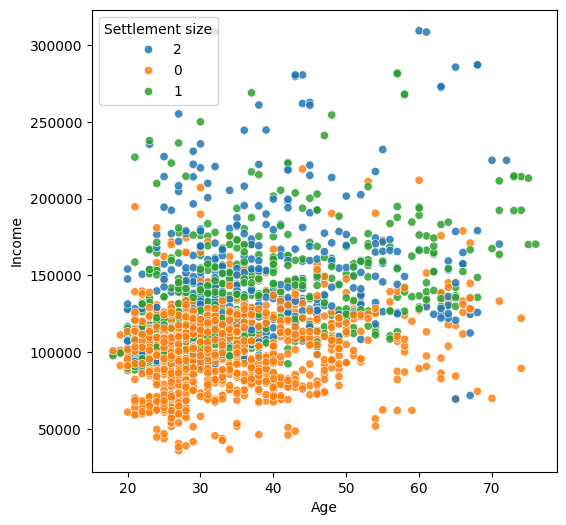

In [18]:
for cat in cat_columns:
    bivariate_scatter('Age', 'Income', cat, customer_info)

#### Multivariate Conclusions

Below are the conclusions for the multivariate analysis.

1) People who live in smaller cities tend to have lower income in the dataset
2) People who have managerial jobs or own businesses have higher income than employees, who have higher income than unemployed
3) Highly educated people tend to be older, but income doesn't seem to be influenced by education level
4) Non-single people tend to have lower income and are younger than single people on average in the dataset
5) Males tend to have a higher income than women when they are older

### General Conclusions about the data

Even though there was no missing data, we noticed a few trends that could be used or could be an expected outcome from the models. 

First, we notice that some numerical features (Age and Income) have a right-skewed normal distribution. We will have to correct that for the model to perform correctly, since it assumes normality in our features. Most likely, a **log transform** will correct this skew.

Second, about the data itself, we noticed that there is a small correlation between age and income, as expected. People in smaller cities have lower income in the dataset. Income is higher as occupation feature is higher. Non-singles (married, divorced, widowed or separated) tend to have lower income than single people, and for some strange reason tend to be younger than single people (in this dataset). When they are older, males tend to have higher income than females. Most unemployed people and married people in the dataset live in small cities. There are more unemployed women than men in the dataset.

### Feature Tranforming and Scaling

#### Normality test for the data

Numerical features showed a right skew in their distributions. We will check if the data is normally distributed or not, by using a normality test from scipy. From our visualizations we can already guess that the data isn't normally distributed, but we run the test to have evidence of precisely that.

In [19]:
from scipy import stats

In [20]:
normaltest_result_income = stats.normaltest(customer_info['Income'])[1]
normaltest_result_age    = stats.normaltest(customer_info['Age'])[1]

print(f'The p-value for the null hypothesis of the Income being Normally distributed is {normaltest_result_income}')
print(f'The p-value for the null hypothesis of the Age    being Normally distributed is {normaltest_result_age}')

The p-value for the null hypothesis of the Income being Normally distributed is 2.5009638879187734e-98
The p-value for the null hypothesis of the Age    being Normally distributed is 3.3428344869999675e-56


The p-value for both features is extremely low, and verifies p-value(Income) << p-value(Age) << 0.05. This means that we can reject the hypothesis that the data is normally distributed, so we know with extreme certainty that the data is **NOT** normally distributed. 

This means we need to transform the data and check for normallity against the transformed data to add it to the model. The K-Means clustering model assumes normallity of distributions, so we need the features to be normalized before feeding them to the model.

#### Transformation cicle

Below, we will go over the same cicle over and over until we achieve a reasonable enough distribution. For that, we create a function that applies a transformation on the data by fitting its parameters and then transforming each value to a newer distribution. We will test a log and a PowerTransform, as the data seems to have a strong right skew, especially the Income feature.

### Feature: Income

##### Log Transformation

In [21]:
def apply_log(column):
    return np.log(column)

def normality_test(column):
    return stats.normaltest(column)

After running the test, we notice that the data isn't normally distributed yet, so the log transformation was unable to get it to a full normal distribution. We will now test scikit learn's **PowerTransformer** to see if we reach better results.

#### PowerTransformer

In [22]:
from sklearn.preprocessing import PowerTransformer

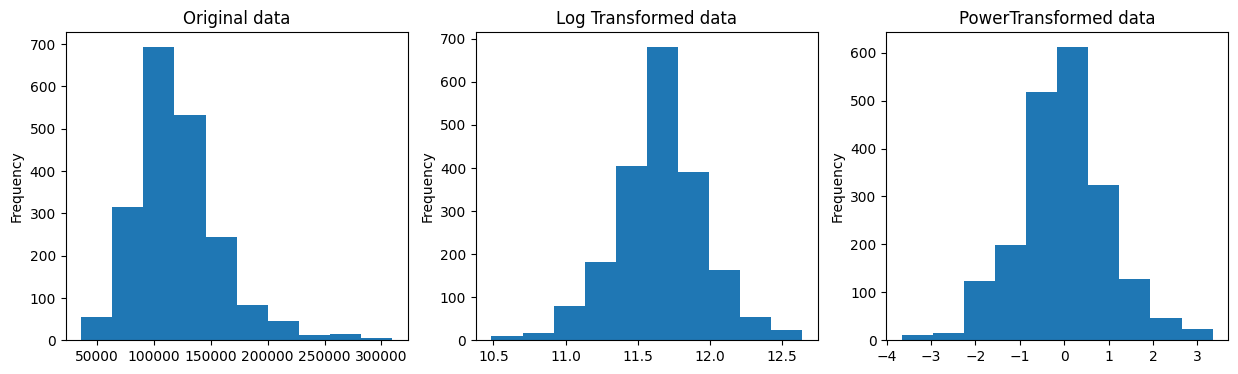

In [24]:
# PowerTransform data
feature = customer_info['Income'].to_numpy().reshape(-1,1)

powtr = PowerTransformer()
feature_transf = powtr.fit_transform(feature)
array_1d = feature_transf.flatten()
feature = pd.Series(data=array_1d, index=list(range(len(array_1d))))

# Log Transform data
log_transformed_income = apply_log(customer_info['Income'])

# Create axis for original data plot (ax1) and transformed data (ax2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4));

# Plot original data & get metrics
customer_info['Income'].plot(kind='hist', ax=ax1)
ax1.title.set_text('Original data')
norm_test1 = normality_test(customer_info['Income'])

# Plot log transformed data & get metrics
log_transformed_income.plot(kind='hist', ax=ax2);
ax2.title.set_text('Log Transformed data')
norm_test2 = normality_test(log_transformed_income)

# Plot power transformed data & get metrics
feature.plot(kind='hist', ax=ax3);
ax3.title.set_text('PowerTransformed data')
norm_test3 = normality_test(feature)

# Create a DataFrame that shows normality test results for each tranformation
norm_results = [norm_test1, norm_test2, norm_test3]
metrics = pd.DataFrame(norm_results, index=['Original data', 'Log transform', 'PowerTransformer'])

In [25]:
normality_test(log_transformed_income)

NormaltestResult(statistic=np.float64(32.357037046565075), pvalue=np.float64(9.413663716188376e-08))

In [26]:
metrics

,statistic,pvalue
Original data,449.473326,2.500964e-98
Log transform,32.357037,9.413664e-08
PowerTransformer,27.859212,8.921730e-07


### Feature: Age

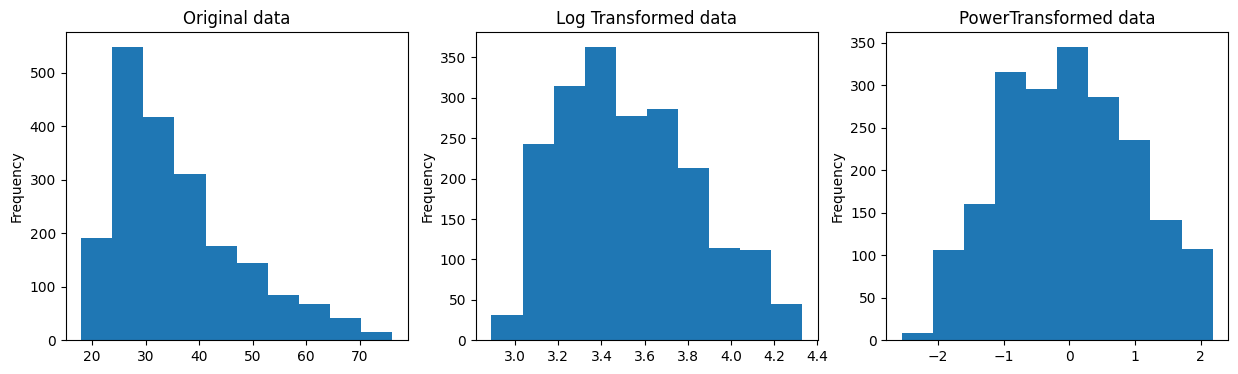

In [27]:
# PowerTransform data
feature2 = customer_info['Age'].to_numpy().reshape(-1,1)

powtr = PowerTransformer()
feature_transf = powtr.fit_transform(feature2)
array_1d = feature_transf.flatten()
feature2 = pd.Series(data=array_1d, index=list(range(len(array_1d))))

# Log Transform data
log_transformed_age = apply_log(customer_info['Age'])

# Create axis for original data plot (ax1) and transformed data (ax2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4));

# Plot original data & get metrics
customer_info['Age'].plot(kind='hist', ax=ax1)
ax1.title.set_text('Original data')
norm_test1 = normality_test(customer_info['Age'])

# Plot log transformed data & get metrics
log_transformed_age.plot(kind='hist', ax=ax2);
ax2.title.set_text('Log Transformed data')
norm_test2 = normality_test(log_transformed_age)

# Plot power transformed data & get metrics
feature2.plot(kind='hist', ax=ax3);
ax3.title.set_text('PowerTransformed data')
norm_test3 = normality_test(feature2)

# Create a DataFrame that shows normality test results for each tranformation
norm_results = [norm_test1, norm_test2, norm_test3]
metrics = pd.DataFrame(norm_results, index=['Original data', 'Log transform', 'PowerTransformer'])

In [28]:
metrics

,statistic,pvalue
Original data,255.475892,3.342834e-56
Log transform,111.094201,7.519703e-25
PowerTransformer,161.196197,9.924088e-36


### Conclusions

After running the tests, we notice that the data isn't normally distributed yet, so neither the log transformation or the PowerTransformer were able to get it to a full normal distribution. Even though we get data that still isn't normally distributed, it has improved significantly from the initial tests. This means that our transformed data is a better approximation to normally distributed data than the original data, so we will use this transformed data instead. 

- For the 'Age' feature, we transform the data using the Log Transform method with our function
- For the 'Income' feature, we use the PowerTransformer from scikit learn

### Definitive Feature transformations:

We broadcast the results of the previous section to our customer_info DataFrame. Finally, we rename the final transformed DataFrame that contains the final features to use in the model. We drop the variables we won't be introducing to the model, which are 'Income', 'Age' and 'ID'.

In [29]:
customer_info['transf_income'] = feature
customer_info['transf_age']    = log_transformed_age

In [30]:
customer_transformed = customer_info.drop(['Income', 'Age', 'ID'], axis=1)
customer_transformed

,Sex,Marital status,Education,Occupation,Settlement size,transf_income,transf_age
0,0,0,2,1,2,0.239545,4.204693
1,1,1,1,1,2,0.869781,3.091042
2,0,0,1,0,0,-0.846121,3.891820
3,0,0,1,1,1,1.303766,3.806662
4,0,0,1,1,1,0.830970,3.970292
...,...,...,...,...,...,...,...
1995,1,0,1,0,0,0.209208,3.850148
1996,1,1,1,1,0,0.051991,3.295837
1997,0,0,0,0,0,-0.948374,3.433987
1998,1,1,1,0,0,-0.545364,3.178054


#### Feature Scaling (MinMaxScaler)

Since there are categorical features scaled between 0 and 1 ('Sex' feature), we will use scikit learn's MinMaxScaler to scale out data between 0 and 1. This is done so that the scale is equivalent to that of the 'Sex' feature (all values will be between zero and one). This is important for the K-Means clustering model, as it uses distance as a measure of similarity. Therefore, if we don't scale the features, we won't get accurate clusters.

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
scaler = MinMaxScaler()
X = scaler.fit_transform(customer_transformed)

In [33]:
X[0]

array([0.        , 0.        , 0.66666667, 0.5       , 1.        ,
       0.55651051, 0.91249369])

# Clustering Models

## K-Means Clustering

K-Means is a clustering algorithm based on distance to determine the similarity of different points. It creates clusters by assigning points to the cluster nearest to them.

### Selecting the correct number of clusters

There are several ways to select the correct number of clusters, but they are all based in the amount of business insight we get from each cluster. It isn't useful to find a lot of clusters if we cannot interpret them, or gain nothing by separating them into different clategories. The number of clusters is an input to the model, but we cannot determine the number of clusters beforehand. So a good approximation is using the elbow method and selecting the number of groups that reduces a metric to a considerable amount; more wouldn't add much information and less would mean the metric could still be improved significantly.

#### Elbow method

In [34]:
from sklearn.cluster import KMeans

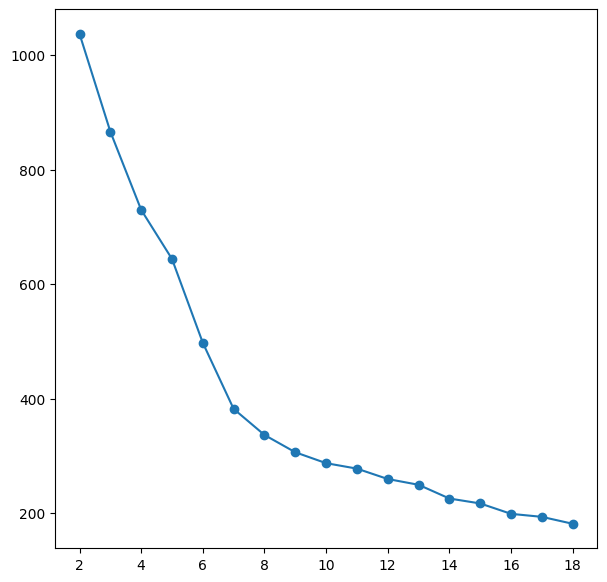

In [35]:
clusters_range=[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
inertias=[]

for c in clusters_range:
    kmeans=KMeans(n_clusters=c, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7,7))
plt.plot(clusters_range,inertias, marker='o')

When running the loop shown above, we notice that the elbow happens around 6-7 clusters, which would be a good approximation. The curve isn't very clear and you could also say that 12 is a good number as well, but you should understand that 12 clusters is generally too much, so we would rather lose some information about the groups our customers belong to, than gaining more accuracy in the clustering used.

Even though we have a somewhat convincing result above, we will use the Silhouette scores to see if we can gain more insight on how many clusters should we use. See the procedure below:

#### Silhouette scores:

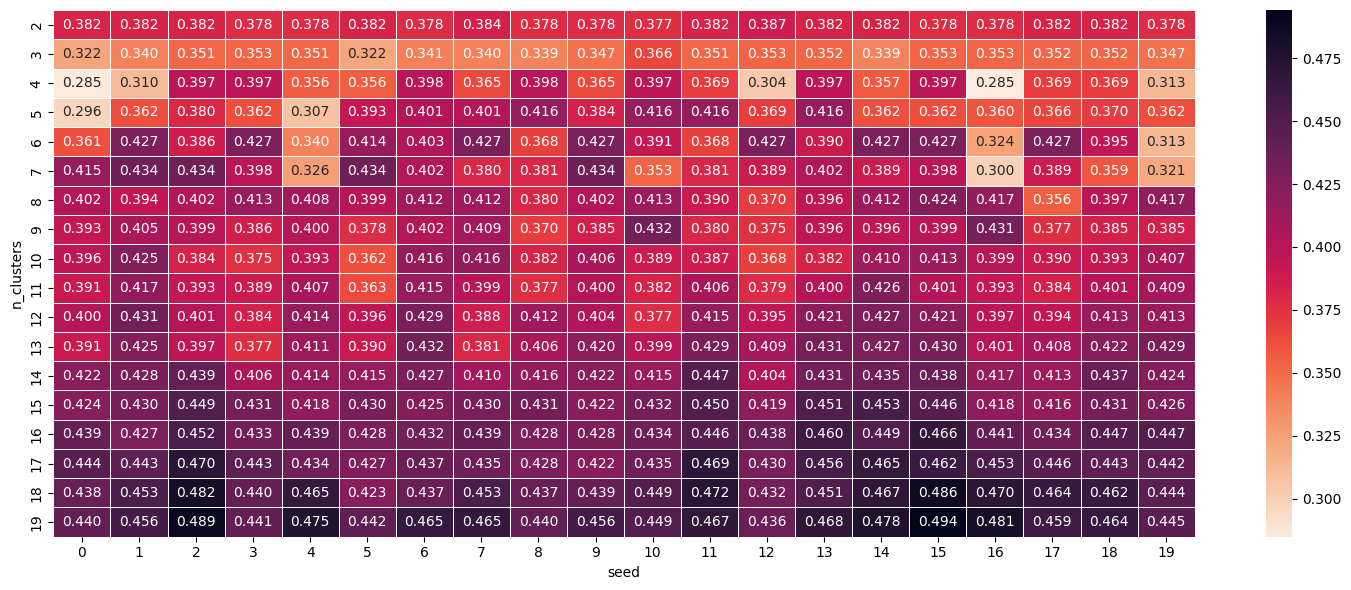

In [36]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range=range(2, 20)
random_range  =range(0, 20)
results=[]

for c in clusters_range:
    for r in random_range:
        clusterer=KMeans(n_clusters=c, random_state=r)
        cluster_labels=clusterer.fit_predict(X)
        silhouette_avg=silhouette_score(X, cluster_labels)
        results.append([c,r,silhouette_avg])

result  =pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km=pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

From the graph shown above, we see that there is a spike in the Silhouette score for 7 clusters, which is coherent with the results we got from the elbow method. This results show that choosing either 6 or 7 clusters should result in somewhat separated groups, which is what we are looking for. We see again that more clusters would reduce the metrics even further, but interpretation for such a small quantity of features with so many clusters would be really hard.

We decide to create 6 and 7 clusters and use our business understanding to determine which classification provides more insights about the customers. Another option would be to select 14 or more, which is unrealistic given the size of the dataset.

## Re-running the models for 6 and 7 clusters:

Below we create the models for 6 and 7 clusters using K-Means and try to understand the results. We will use PCA to visualize the data and determine if the 6-7 clusters we selected provide good inter-cluster cohesion and cluster separation. If not, we will re-run this approach with a Density-Based model and see if we get better results.

#### Creating a 3D dataset with PCA

In [37]:
from sklearn.decomposition import PCA

In [38]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

In [39]:
X_pca_df = pd.DataFrame(data=X_pca, columns=['X1', 'X2', 'X3'])

#### Applying K-Means with 6 clusters and visualizing the results with PCA decomposition

In [40]:
kmeans=KMeans(n_clusters=6, random_state=0).fit(X)

We add the labels of each row to the DataFrame so we can make the plotting process simpler. In order to remember that we are talking about a categorical result in the labels columns, we will later convert them to string-types.

In [41]:
labels = kmeans.labels_
X_pca_df['Labels'] = labels

In [43]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [44]:
X_pca_df.head()

,X1,X2,X3,Labels
0,-0.829143,0.350518,0.162403,0
1,0.531854,0.719504,0.230299,4
2,-0.489493,-0.693627,-0.175269,2
3,-0.712487,-0.027906,0.049583,0
4,-0.718334,-0.036815,0.052850,0


In [45]:
X_pca_df['Labels'] = X_pca_df['Labels'].astype(str)

#### Visualization

We have already clustered the data into 6 distinct groups and done PCA to get 3 features out of the 7 we originally had. It is always important to remember that using PCA inherently means a loss of information, so the projections of the data in the new features X1, X2 and X3 can have some overlapping points, but in reality, when using K-Means clustering the border points are clearly defined.

In [48]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"

fig = px.scatter_3d(X_pca_df, x='X1', y='X2', z='X3',
              color=X_pca_df['Labels'])
fig.show()

We should first notice that the clusters are quite separated and the algorithm seems to be doing the cluster separation well, as the frontiers between clusters seem quite clear.

Now we should create a Results DataFrame that includes the labels and apply filtering methods to infer information about the clusters provided by the K-Means model. Our objective is to define what type of customer is reflected in each cluster!

In [49]:
results_df = customer_info.drop(['ID', 'transf_income', 'transf_age'], axis=1)
results_df['Labels'] = kmeans.labels_
results_df = results_df.astype({'Sex':'int32', 'Marital status':'int32', 'Education':'int32', 'Occupation':'int32', 'Settlement size':'int32'})
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int32
 1   Marital status   2000 non-null   int32
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int32
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int32
 6   Settlement size  2000 non-null   int32
 7   Labels           2000 non-null   int32
dtypes: int32(6), int64(2)
memory usage: 78.3 KB


## Summary statistics of each cluster

Now let's build a program that calculates statistics for the data for each label. Our aim with this is to have a general sense of the values within each cluster, so we need central tendency statistics that look at the entire dataset we are interested in, like the mean, median, std. dev. and so forth. The .describe() method does precisely that for us. It shows the mean and std. dev., and the 50% column shows the median of the data.

In [50]:
summary = {}

for index in range(6):
    summary[index] = results_df[results_df['Labels'] == index].describe().T  # .describe method provides general statistics about the data

Above, we created a dictionary called summary which contains all the central tendency statistics we wanted to know. Min and Max statistics give us an idea of the range of the data, while the mean and median give us the central tendency of the data. Finally, the standard deviation gives us a notion of variance within the data.

### Interpreting results

Now, let's try to interpret the results we got for each cluster with the help of this statistics and our general knowledge of the data. Remember we gathered some information about the data during the data visualization section that may come in handy here. For example, we noticed that 'Age' wasn't a good indicator of separation from the clusters as data points from this feature within the same age range belonged to different categories.

We will use **two strategies to interpret the data points**. The first is using the summary descriptive statistics from the **.describe()** method. This gives us a good general idea of the data within each label, but it's also incomplete, as we don't have an idea of distribution. Therefore, we will make use of the **.hist()** method for DataFrames to add another layer of depth into our analysis with the distribution of the data.

Notice the clusters are not analyzed in order, due to the fact that I've already conducted a quick analysis to make sense of the data.

### Cluster 0

In [51]:
summary[0]

,count,mean,std,min,25%,50%,75%,max
Sex,517.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Marital status,517.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Age,517.0,40.001934,11.945532,20.0,31.0,37.0,47.0,75.0
Education,517.0,0.822050,0.612576,0.0,0.0,1.0,1.0,2.0
Income,517.0,145373.611219,38286.684815,82398.0,119276.0,136323.0,159757.0,287247.0
Occupation,517.0,1.266925,0.484577,0.0,1.0,1.0,2.0,2.0
Settlement size,517.0,1.529981,0.507283,0.0,1.0,2.0,2.0,2.0
Labels,517.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


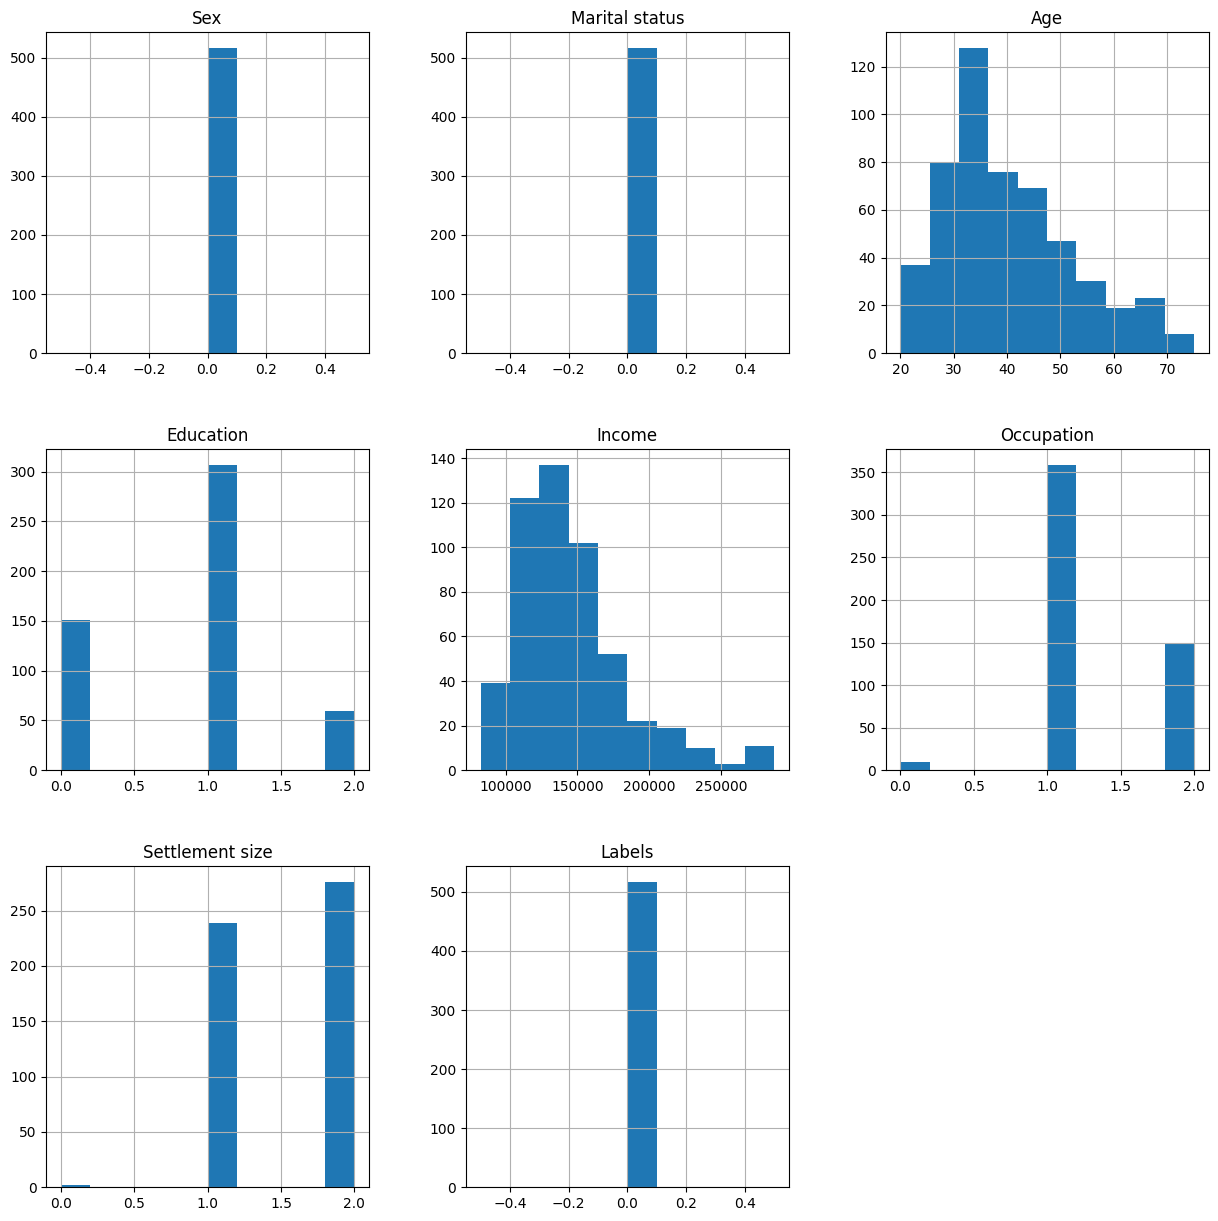

In [52]:
results_df[results_df['Labels'] == 0].hist(figsize=(15,15));

#### Conclusion Cluster 0:

This cluster groups single men with medium income, generally unemployed who live in small cities. We could be tempted to say that their Age is between 20 and 40 primarily or that education is generally high-school level or below, but as we'll see further into the analysis, this happens in other clusters as well, so we conclude that age or education are good separators of clusters in this dataset for clusters 1 and 3.

### Cluster 3:

In [53]:
summary[3]

,count,mean,std,min,25%,50%,75%,max
Sex,253.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Marital status,253.0,0.747036,0.435572,0.0,0.0,1.0,1.0,1.0
Age,253.0,31.806324,9.869689,18.0,26.0,29.0,35.0,67.0
Education,253.0,1.098814,0.481934,0.0,1.0,1.0,1.0,3.0
Income,253.0,118222.343874,19348.401423,89863.0,103926.0,114784.0,126009.0,211229.0
Occupation,253.0,1.027668,0.164345,1.0,1.0,1.0,1.0,2.0
Settlement size,253.0,0.051383,0.221216,0.0,0.0,0.0,0.0,1.0
Labels,253.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


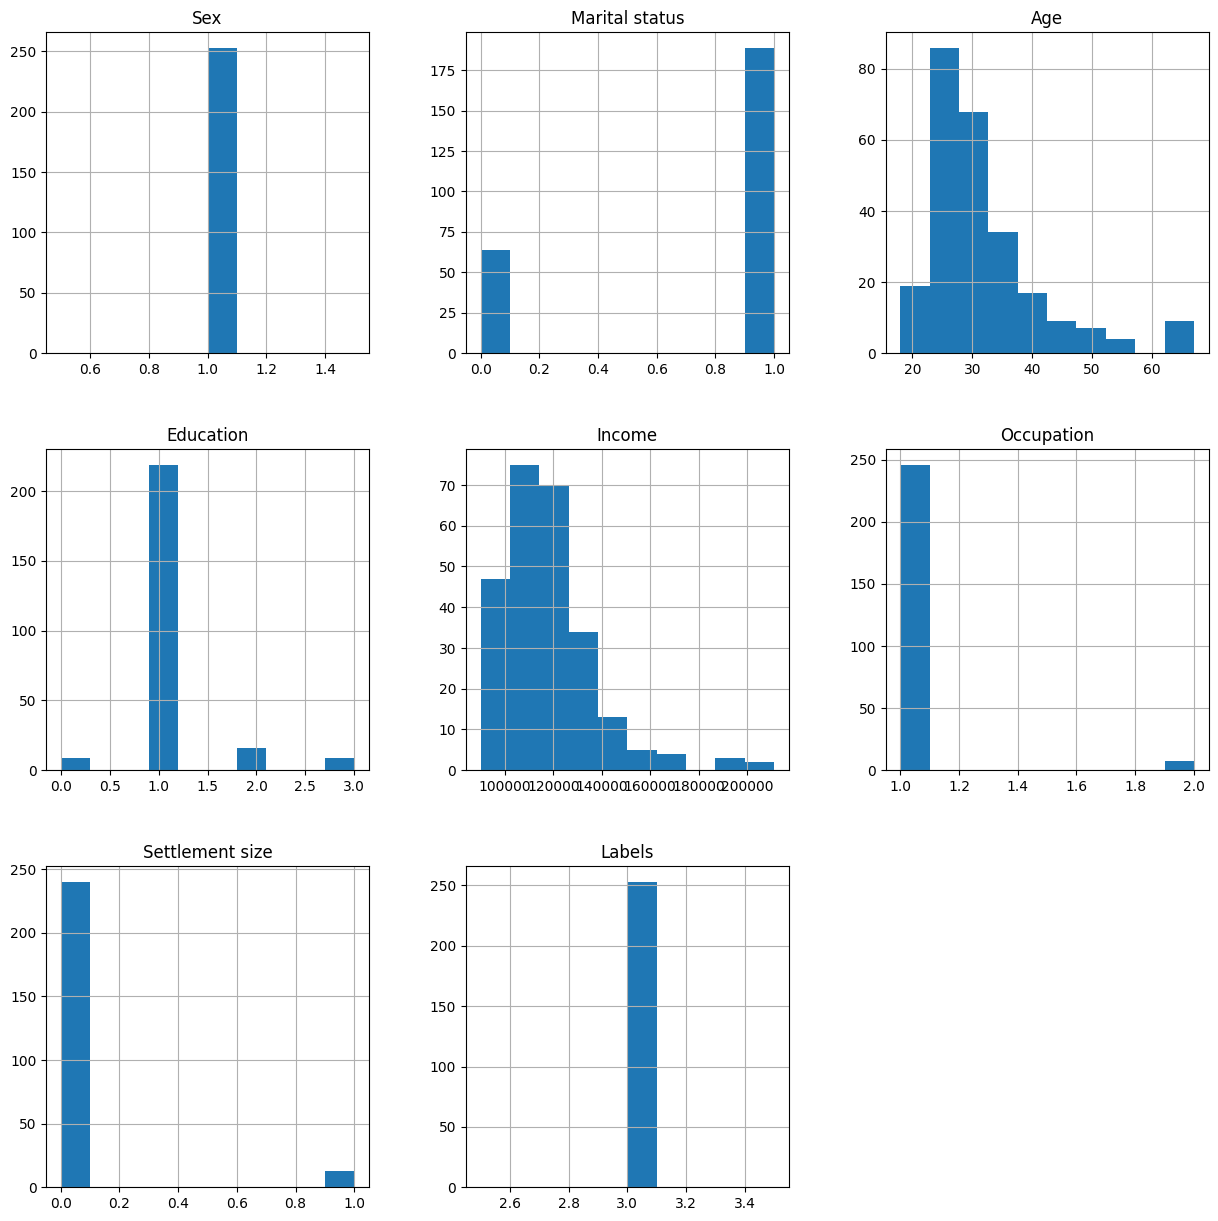

In [54]:
results_df[results_df['Labels'] == 3].hist(figsize=(15,15));

#### Conclusions Cluster 3:

This cluster is also represented by single men, but with higher income and with management or self-employed occupations. They live in medium to large cities. Education is similar to cluster one, with most being educated up to high-school level or below. Ages seem to be within the same range as cluster one, so they won't be taken into account.

### Cluster 1

In [55]:
summary[1]

,count,mean,std,min,25%,50%,75%,max
Sex,355.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Marital status,355.0,0.678873,0.467568,0.0,0.0,1.0,1.0,1.0
Age,355.0,34.028169,10.905309,19.0,26.0,31.0,40.5,71.0
Education,355.0,1.149296,0.534376,0.0,1.0,1.0,1.0,3.0
Income,355.0,89089.935211,22167.902140,35832.0,72798.5,87537.0,104932.0,181003.0
Occupation,355.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Settlement size,355.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Labels,355.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


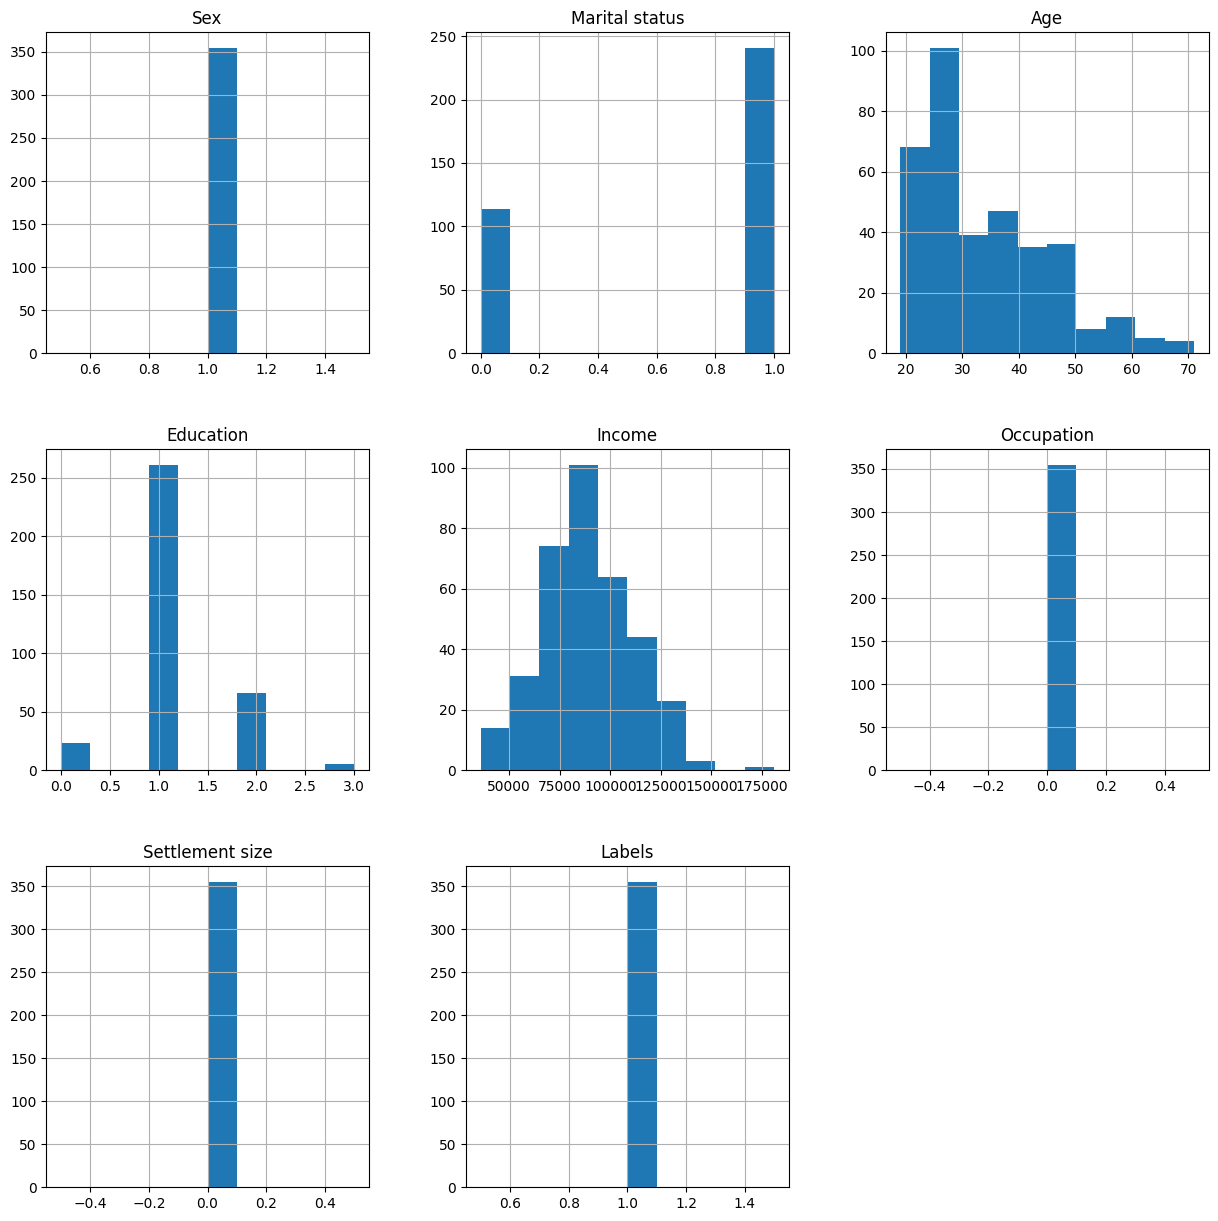

In [56]:
results_df[results_df['Labels'] == 1].hist(figsize=(15,15));

#### Conclusions Cluster 1

This cluster is represented by non-single women with medium income and high-school or above-level education. They live in small cities and are either unemployed or work as employees/officials. Age is still within the same ranges as before, so we won't take it into account.

### Cluster 2:

In [57]:
summary[2]

,count,mean,std,min,25%,50%,75%,max
Sex,312.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
Marital status,312.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
Age,312.0,37.567308,10.633108,21.0,29.75,36.0,42.00,74.0
Education,312.0,0.737179,0.579524,0.0,0.00,1.0,1.00,2.0
Income,312.0,102566.410256,26584.893960,43684.0,81804.00,103618.5,120396.75,219319.0
Occupation,312.0,0.365385,0.501913,0.0,0.00,0.0,1.00,2.0
Settlement size,312.0,0.060897,0.239526,0.0,0.00,0.0,0.00,1.0
Labels,312.0,2.000000,0.000000,2.0,2.00,2.0,2.00,2.0


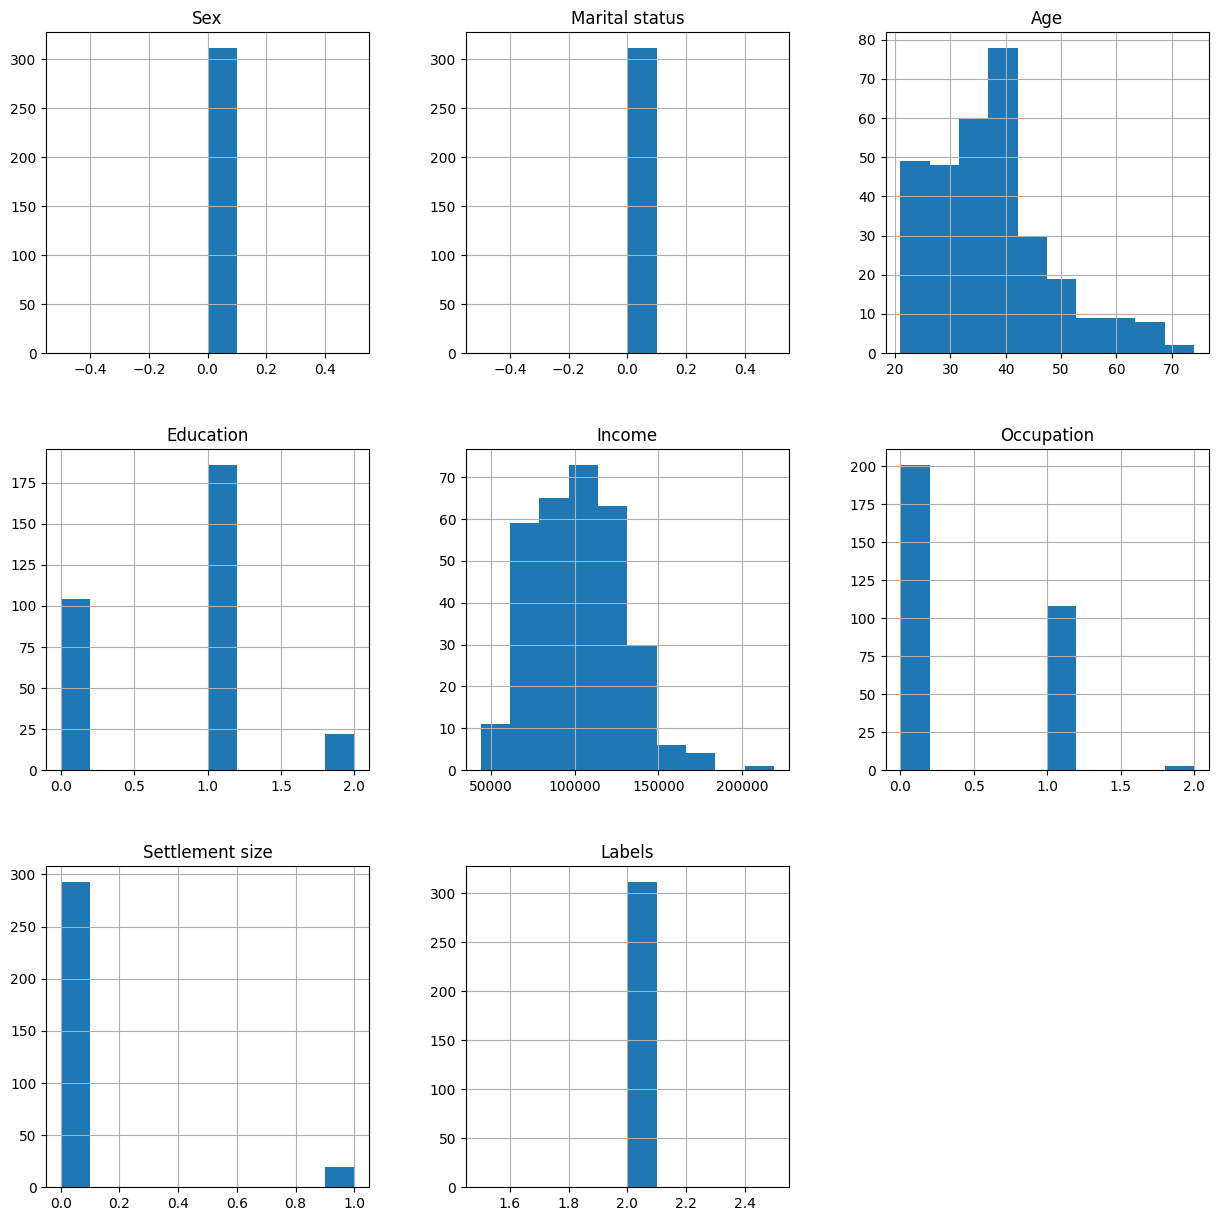

In [58]:
results_df[results_df['Labels'] == 2].hist(figsize=(15,15));
plt.savefig('cluster4_results')

#### Conclusions Cluster 2:

Cluster 2 is represented by non-single females with high-school or higher-level education, high income who are employed or self-employed. They live in medium to large cities. Again, the distribution of Age is similar in this cluster, so no extra information is obtained from this feature. 

You could argue that the age of people in clusters 1 and 2 are generally younger (we use the median of the age to get 28.5 & 29 years in clusters 1 and 2 respectively) than people in clusters 0 and 3, which comparatively have older people in them (using the median again we get 36 and 37 for clusters 0 and 3 respectively). The difference is quite small, but not insignificant, as we'll check in the following cell. 

Below we conduct a Hypothesis Test which assumes their data comes from the same sample, and we arrive at the conclusion that the means are significantly different, with a statistical significance of 95%. This means that we can assume that the ages of groups 0 and 3 are significantly different from ages in groups 1 and 2.

Despite this effort, we still don't have a good grasp on the difference between the clusters regarding Age, so we will still ignore this feature.

In [60]:
from scipy.stats import ttest_ind
import numpy as np

age_cluster_0 = results_df[results_df['Labels'] == 0]['Age']
age_cluster_1 = results_df[results_df['Labels'] == 1]['Age']
age_cluster_2 = results_df[results_df['Labels'] == 2]['Age']
age_cluster_3 = results_df[results_df['Labels'] == 3]['Age']

first_clusters  = [1, 2]
second_clusters = [0, 3]
real_clusters = [age_cluster_0, age_cluster_1, age_cluster_2, age_cluster_3]

for num_clust_1 in first_clusters:
    for num_clust_2 in second_clusters:
        ttest,pval = ttest_ind(real_clusters[num_clust_1], real_clusters[num_clust_2])
        print(f'p-value of {num_clust_1} vs {num_clust_2} is:',pval)
        if pval <0.05:
            print("we reject null hypothesis")
        else:
            print("we accept null hypothesis")


p-value of 1 vs 0 is: 1.4214806763572844e-13
we reject null hypothesis
p-value of 1 vs 3 is: 0.010259281143789444
we reject null hypothesis
p-value of 2 vs 0 is: 0.003154777212150631
we reject null hypothesis
p-value of 2 vs 3 is: 8.813554144538263e-11
we reject null hypothesis


### Cluster 4

In [61]:
summary[4]

,count,mean,std,min,25%,50%,75%,max
Sex,306.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Marital status,306.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Age,306.0,34.506536,13.166585,18.0,25.0,29.5,40.0,76.0
Education,306.0,1.336601,0.567797,1.0,1.0,1.0,2.0,3.0
Income,306.0,135973.081699,37652.533654,88800.0,108455.0,126778.5,153807.0,309364.0
Occupation,306.0,1.150327,0.417192,0.0,1.0,1.0,1.0,2.0
Settlement size,306.0,1.369281,0.483401,1.0,1.0,1.0,2.0,2.0
Labels,306.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0


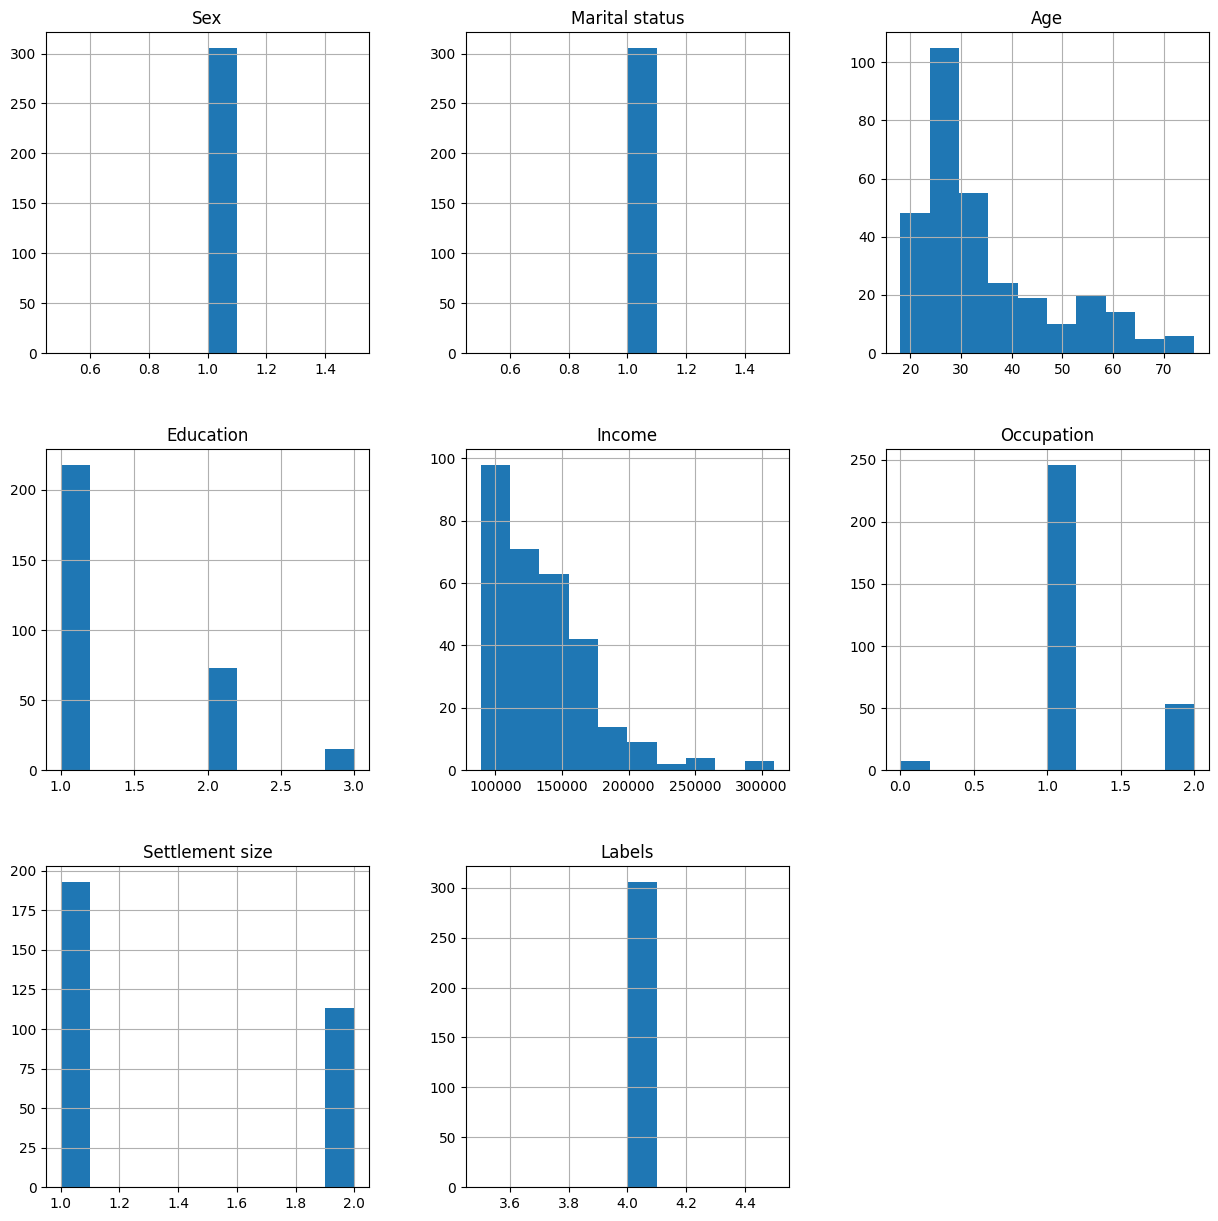

In [62]:
results_df[results_df['Labels'] == 4].hist(figsize=(15,15));

#### Conclusions Cluster 4:

Cluster 4 is represented by non-single males with high-school or higher level education and low-medium income. They are mostly employed as employees/officials. Note that this customers live in small, medium and large cities equally, so we are not taking it into account in this analysis. Age has the same problem as with other clusters, so it isn't taken into account.

### Cluster 5

In [63]:
summary[5]

,count,mean,std,min,25%,50%,75%,max
Sex,257.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Marital status,257.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Age,257.0,33.968872,10.759035,18.0,26.0,31.0,40.0,67.0
Education,257.0,1.268482,0.501851,1.0,1.0,1.0,1.0,3.0
Income,257.0,122976.723735,38529.241076,62263.0,96769.0,115369.0,146519.0,280570.0
Occupation,257.0,0.933852,0.630834,0.0,1.0,1.0,1.0,2.0
Settlement size,257.0,0.918288,0.827468,0.0,0.0,1.0,2.0,2.0
Labels,257.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0


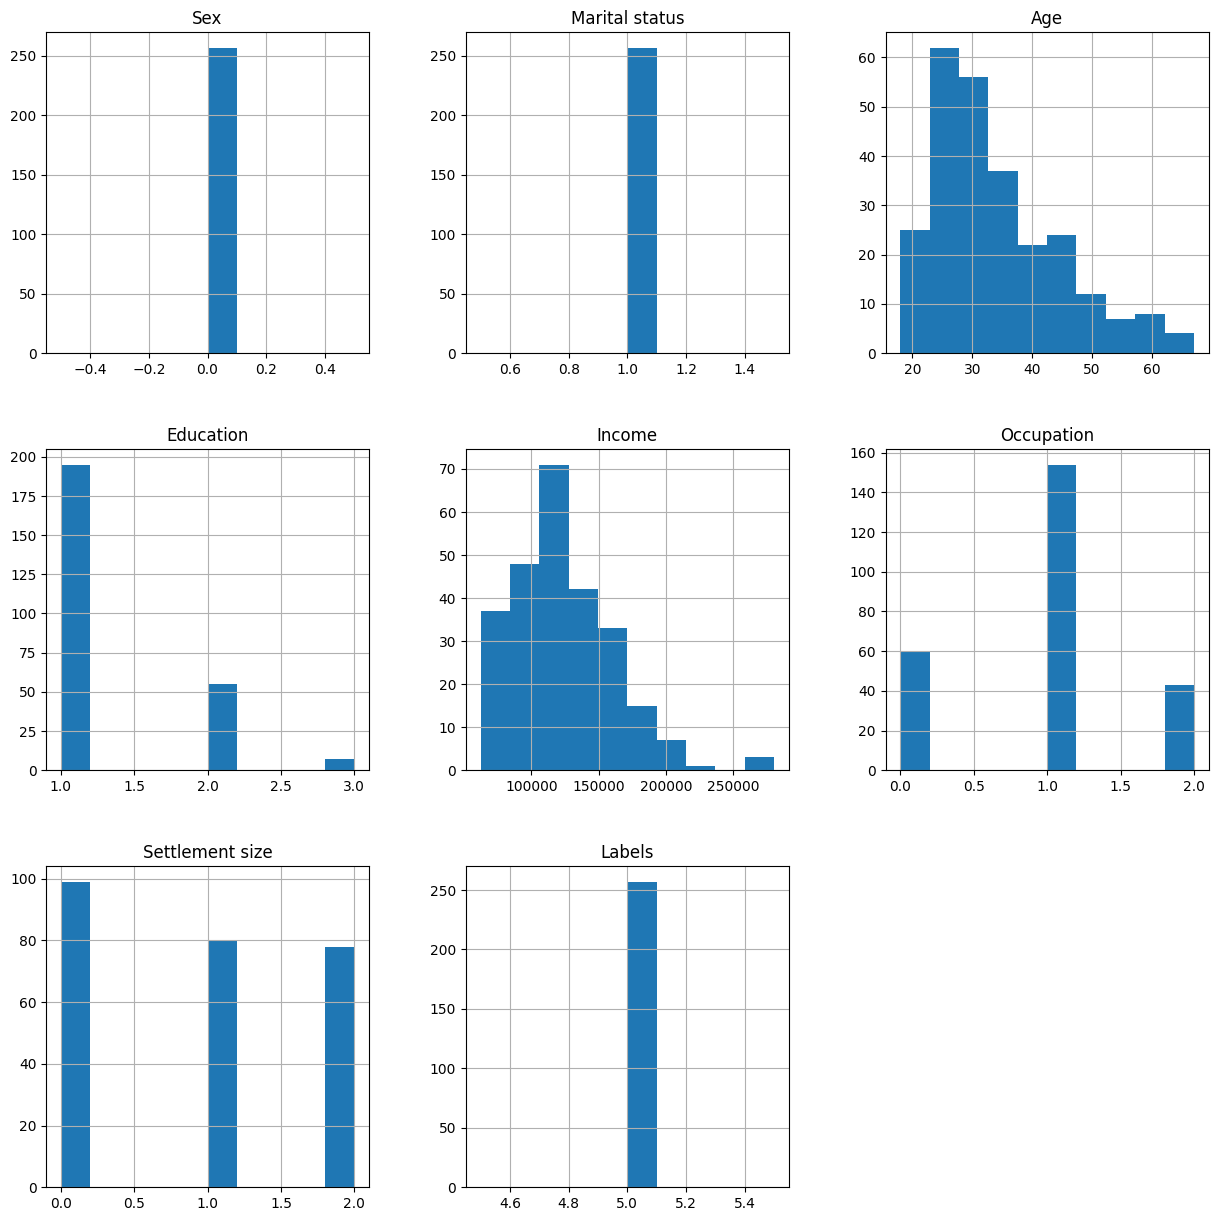

In [64]:
results_df[results_df['Labels'] == 5].hist(figsize=(15,15));

#### Conclusions Cluster 5:

Cluster 5 is represented by single females of low education. The majority of them have a high-school level education, they live in small cities and are either unemployed or work as employees.

## Alternative ways to interpret clusters:

### Using cluster centroids as a means of understanding the clusters themselves

When we need to get a quick idea of the clusters' statistics by cluster, we can also use the centroids of each cluster, as we will show below. The problem with this method is that it provides a sense of central tendency, but it doesn't tell the whole story. Outliers may be affecting the values of each centroid, and so we have to handle this metric with care.

However, it will be a good measure of accuracy from our already created clusters.

In [65]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = results_df.columns[:7], index = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
C0,-5.551115e-16,6.661338e-16,0.274017,6.334623e-01,7.649903e-01,0.615822,0.524984
C1,1.000000e+00,6.788732e-01,0.383099,5.551115e-17,1.110223e-16,0.387070,0.409831
C2,-4.440892e-16,-2.220446e-16,0.245726,1.826923e-01,3.044872e-02,0.451144,0.484804
C3,1.000000e+00,7.470356e-01,0.366271,5.138340e-01,2.569170e-02,0.526578,0.368226
C4,1.000000e+00,1.000000e+00,0.445534,5.751634e-01,6.846405e-01,0.583473,0.408960
C5,-3.885781e-16,1.000000e+00,0.422827,4.669261e-01,4.591440e-01,0.530253,0.409658


You can use the information in the centroid to make some sense of the data, but as with the central tendency metrics, you will generally underfit your descriptions, as centroids don't necessarily show the whole picture of the data within each cluster. You can see that gender and marital status of most clusters will be correct, but numerical features, and even some categorical features are harder to interpret. this is why we prefer the Decision Tree method shown below.

### Decision Tree as a method to interpret clusters:

An alternative way to visualize and understand clusters is by way of using decision trees. We can make a decision tree predict the labels of each cluster we have determined, and in doing so the tree will determine splitting points based on the features we pass to the model. In this way, we can create the cluster descriptions based on how the decision tree splits the data.

We will use graphviz as our tree visualization tool. If you haven't downloaded this library, but have matplotlib, there is also an option to plot trees with the matplotlib library, but the visualization is way clearer with graphviz!

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz

In [67]:
clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 5)

In [68]:
X_clusters = results_df.drop('Labels', axis=1)
y_clusters = results_df['Labels']

clf.fit(X_clusters, y_clusters)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)

#### Evaluating the model to make sure interpretations are accurate:

In [69]:
from sklearn.metrics import classification_report, confusion_matrix

In [70]:
predictions = clf.predict(X_clusters)
print(classification_report(y_clusters, predictions))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       517
           1       1.00      1.00      1.00       355
           2       0.96      1.00      0.98       312
           3       1.00      1.00      1.00       253
           4       1.00      1.00      1.00       306
           5       1.00      1.00      1.00       257

    accuracy                           0.99      2000
   macro avg       0.99      1.00      0.99      2000
weighted avg       0.99      0.99      0.99      2000



The model seems extremely accurate at predicting the values of the classes, so we can expect the split points to be quite accurate as well. We will proceed with the interpretation of the model using this technique.

### Visualization of the Clustering Tree

I'm calling the following tree a 'Clustering Tree' as it aids in defining the clustering algorithm parameters and gives and idea of how the data should be interpreted from our results. The clustering tree returns the results shown below, it is important to note that clusters are named in the same order as they were defined in previous sections.

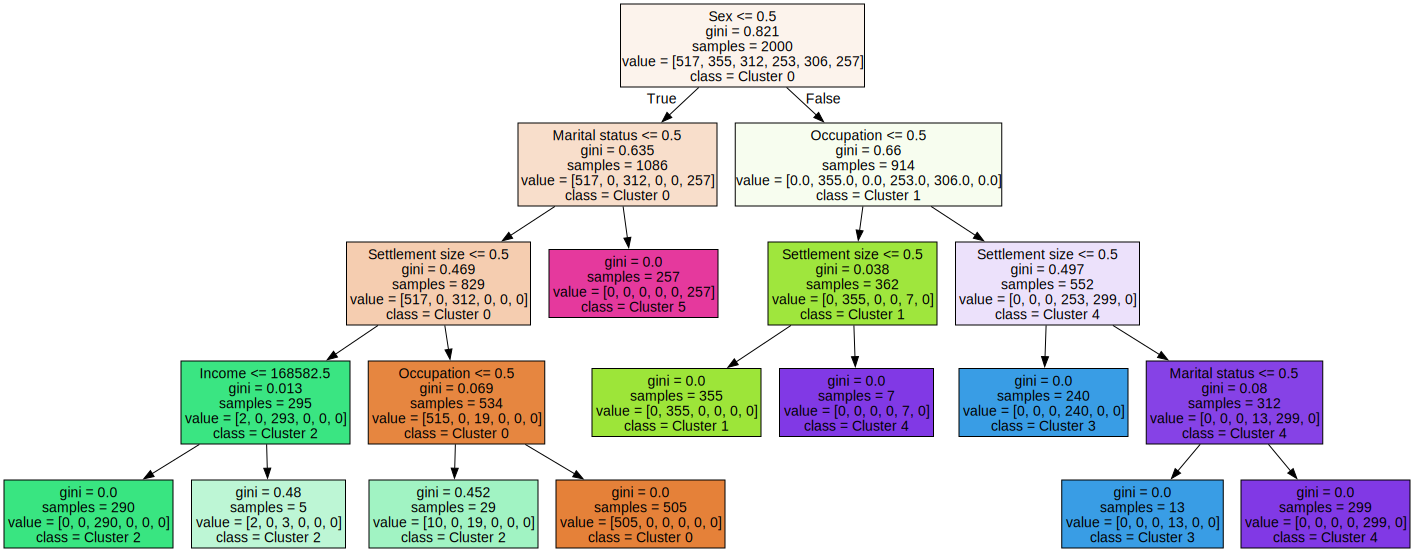

In [72]:
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=results_df.columns[:7],  
                                class_names=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph
#plt.savefig('DecisionTree.png')

### Clusters according to the Decision Tree:

Below you can see the interpretation of each cluster depending on the features that separate the customers in either group. You can see that even though we used different methods to achieve the grouping descriptions, the results were almost identical. The interesting fact about the Decision Tree is that it can be pruned to take only the most important features into account, and so it provides a much simpler version that can be summarized better, as it is done below. We will stay with the clusters obtained by this method for the reasons explained before.

Notice that there are clusters like number 4, where you only need to know 2 features about the customer to group them into cluster 4. This is a very simple rule to use in practice.

### Summarized Clusters:

Cluster 0 --> Single + Small city + Male + Employed (employee/self-employed) >>> (we ignore Income as both leafs return the Cluster 0 label)

Cluster 1 --> Non-single + Female + small city + unemployed or employees (there are very little cases of medium/big city + unemployed so we discard them)
                                                  
Cluster 2 --> Non-single + Female + medium/large city + management/self-employed (there are very little cases of small city + self-employed so we discard them)

Cluster 3 --> Single + Medium/big city + Male + Employed (employee or self-employed)

Cluster 4 --> Non-single + Males

Cluster 5 --> Single + Small city + Female (there are very little cases of medium/big city + Female so we discard them)